In [1]:
import os
import random
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow, concatenate_images
from skimage import io, transform
from skimage.measure import label, regionprops
from sklearn.model_selection import train_test_split
from PIL import Image 

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set paths
data_root = '../input/airbus-ship-detection/'
path_train = os.path.join(data_root,'train_v2')
path_test = os.path.join(data_root,'test_v2')


Utils

In [3]:

# Decode masks in CSV 
# Ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

# Convert CSV masks to image for a given image name 
def maskcsv_to_img(masks, img_name):
    masks_img = np.zeros((768,768))
    masks_bin = masks.loc[masks['ImageId'] == img_name, 'EncodedPixels'].tolist()
    for mask in masks_bin:
        if isinstance(mask, str):
            masks_img += rle_decode(mask)
    return np.expand_dims(masks_img, -1)

# Convert masks in a list to an image
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)
    
# Show an image and its corresponding mask
def imshow_mask(img, mask):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    
    fig, axs = plt.subplots(1,2, figsize=(10,30))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[1].imshow(mask)
    axs[1].axis('off')

    
def imshow_gt_out(img, mask_gt, mask_out):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    mask_gt = mask_gt.numpy().transpose((1, 2, 0))
    mask_gt = np.clip(mask_gt, 0, 1)

    mask_out = mask_out.numpy().transpose((1, 2, 0))
    mask_out = np.clip(mask_out, 0, 1)

    fig, axs = plt.subplots(1,3, figsize=(10,30))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title("Input image")
    axs[1].imshow(mask_gt)
    axs[1].axis('off')
    axs[1].set_title("Ground truth")
    axs[2].imshow(mask_out)
    axs[2].axis('off')
    axs[2].set_title("Model output")
    plt.subplots_adjust(wspace=0, hspace=0)

def imshow_overlay(img, mask, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    fig = plt.figure(figsize = (6,6))
    plt.imshow(mask_overlay(img, mask))
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

def mask_overlay(image, mask, color=(0, 1, 0)):
    """
    Helper function to visualize mask on the top of the image
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]    
    return img
    
# This function transforms EncodedPixels into a list of pixels
# Check our previous notebook for a detailed explanation:
# https://www.kaggle.com/julian3833/2-understanding-and-plotting-rle-bounding-boxes
def rle_to_pixels(rle_code):
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1:-2:2])) 
                 for pixel_position in range(start, start + length)]
    return pixels


Total number of images (original): 192556
Total number of images (after removing corrupted images): 192555


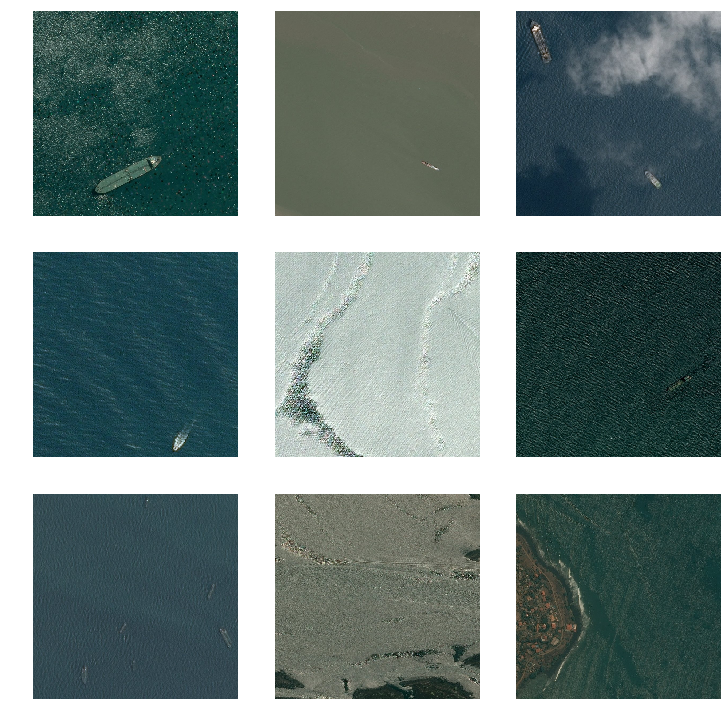

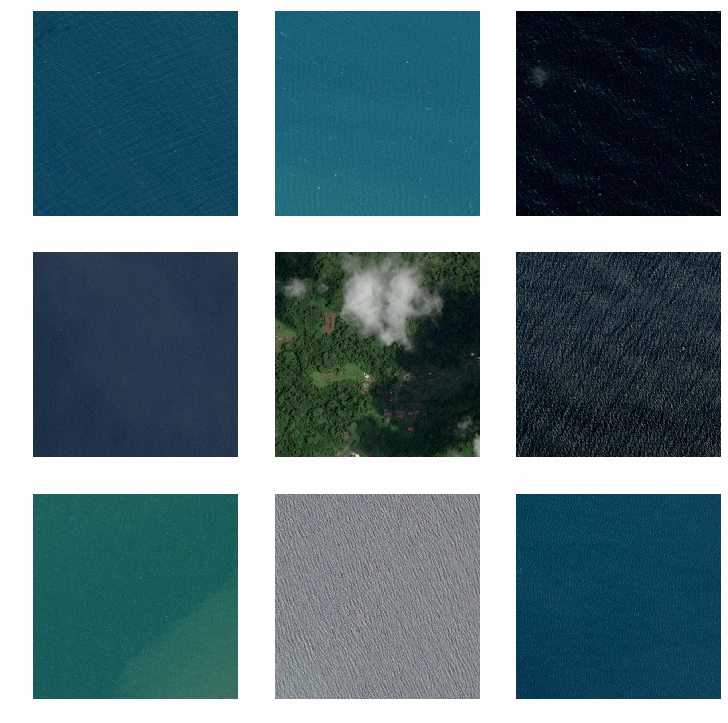

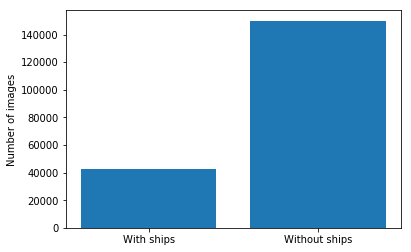

Number of images with ships : 42556 | Number of images without ships : 149999  (x3.5)


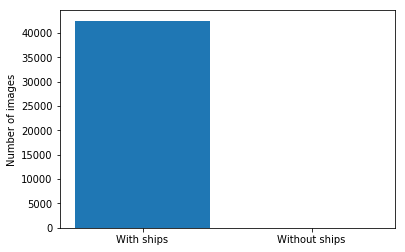

Number of images with ships : 42556 | Number of images without ships : 0  (x0.0)


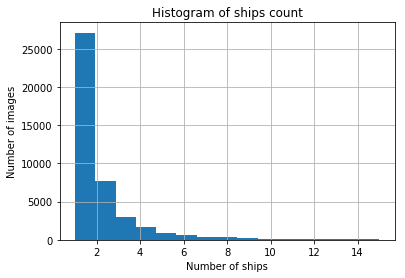

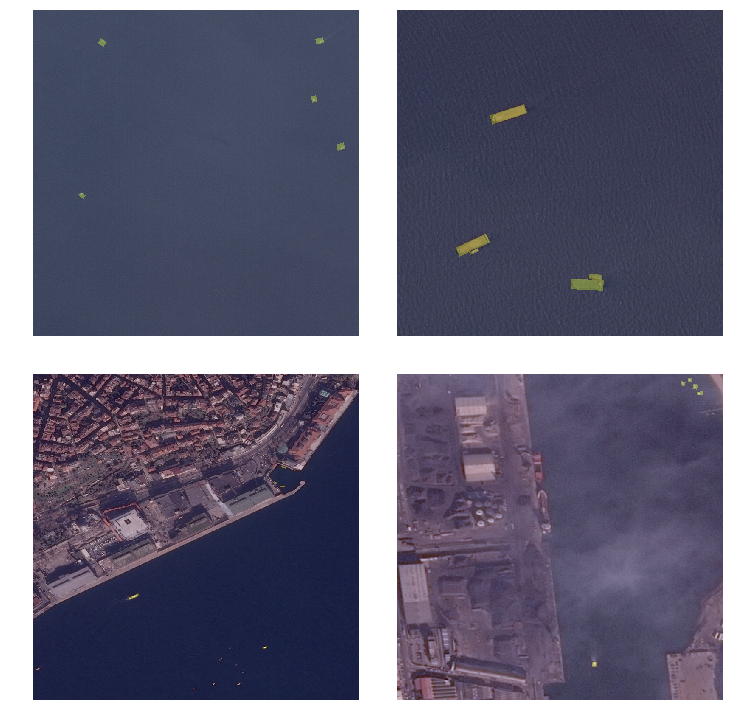

Number of training images : 40428


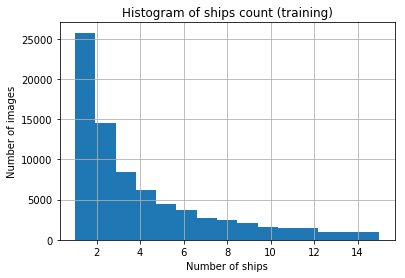

Number of validation images : 2128


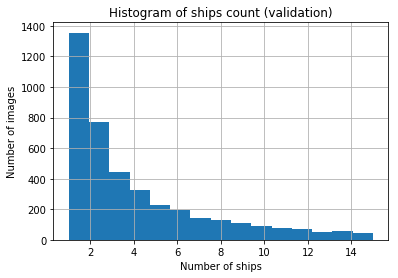

In [4]:
# Read CSV as dataframe
masks = pd.read_csv(os.path.join(data_root, 'train_ship_segmentations_v2.csv'))
print('Total number of images (original): %d' % masks['ImageId'].value_counts().shape[0])

# Create a dataframe with unique images id as indexes and number of ships and image sizes as new columns
masks = masks[~masks['ImageId'].isin(['6384c3e78.jpg'])] # remove corrupted file
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
print('Total number of images (after removing corrupted images): %d' % masks['ImageId'].value_counts().shape[0])

# Plot some images with ships
img_wships = masks[~masks['EncodedPixels'].isna()].sample(9)
fig, arr = plt.subplots(3,3, figsize=(10,10), constrained_layout=True)
for i, img in enumerate(img_wships['ImageId']):
    r = int(i / 3)
    c = i % 3
    arr[r,c].imshow(imread(os.path.join(path_train, img)))
    arr[r,c].axis('off')
plt.show()

# Plot some images without ships
img_woships = masks[masks['EncodedPixels'].isna()].sample(9)
fig, arr = plt.subplots(3,3, figsize=(10,10), constrained_layout=True)
for i, img in enumerate(img_woships['ImageId']):
    r = int(i / 3)
    c = i % 3
    arr[r,c].imshow(imread(os.path.join(path_train, img)))
    arr[r,c].axis('off')
plt.show()

# Count number of ships per image
df_wships = masks.dropna()
df_wships = df_wships.groupby('ImageId').size().reset_index(name='counts')
df_woships = masks[masks['EncodedPixels'].isna()]

# Make a plot
plt.bar(['With ships','Without ships'], [len(df_wships), len(df_woships)])
plt.ylabel('Number of images')
plt.show()

print('Number of images with ships : %d | Number of images without ships : %d  (x%0.1f)' \
      % (df_wships.shape[0], df_woships.shape[0], df_woships.shape[0] / df_wships.shape[0]))
## -> Unbalanced dataset

# Remove images without ships to help getting a more balanced dataset
masks = masks.dropna()
df_woships = masks[masks['EncodedPixels'].isna()]

# Make a plot
plt.bar(['With ships','Without ships'], [len(df_wships), len(df_woships)])
plt.ylabel('Number of images')
plt.show()

print('Number of images with ships : %d | Number of images without ships : %d  (x%0.1f)' \
      % (df_wships.shape[0], df_woships.shape[0], df_woships.shape[0] / df_wships.shape[0]))
## -> Balanced dataset

# Plot histogram
hist = df_wships.hist(bins=df_wships['counts'].max())
plt.title("Histogram of ships count")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show(hist)

# Plot images with 15 ships
df_w15ships = df_wships.loc[df_wships['counts'] == 5]
list_w15ships = df_w15ships.values.tolist()

fig, axarr = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
for i in range(4):
    rd_id = random.randrange(len(list_w15ships))
    img_masks = masks.loc[masks['ImageId'] == str(list_w15ships[rd_id][0]), 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask)
        
    r = int(i / 2)
    c = i % 2

    axarr[r][c].imshow(imread(os.path.join(path_train, list_w15ships[rd_id][0])))
    axarr[r][c].imshow(all_masks, alpha=0.3)
    axarr[r][c].axis('off')
                    
plt.show()

# Split dataset into training and validation sets
# statritify : same histograms of numbe of ships
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')

train_ids, val_ids = train_test_split(unique_img_ids, test_size=0.05, stratify=unique_img_ids['counts'], random_state=42)
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, val_ids)

train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)

print('Number of training images : %d' % train_df['ImageId'].value_counts().shape[0])
train_df['counts'].hist(bins=train_df['counts'].max())
plt.title("Histogram of ships count (training)")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show()

print('Number of validation images : %d' % valid_df['ImageId'].value_counts().shape[0])
valid_df['counts'].hist(bins=valid_df['counts'].max())
plt.title("Histogram of ships count (validation)")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show()